### imports

In [1]:
!pip install scikit-learn==1.3.2
!pip install numpy==1.26.2
!pip install pandas==1.4.3
!pip install torch==2.2

In [2]:
import os
import math
import copy
from itertools import zip_longest

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim

### set random seed for reproducibility

In [3]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

In [4]:
RANDOM_STATE = 42
set_random_seed(RANDOM_STATE)

### download dataset

In [5]:
DATASET_LINK="https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"

In [6]:
!wget -nc $DATASET_LINK
!unzip -n ml-latest-small.zip

File ‘ml-latest-small.zip’ already there; not retrieving.

Archive:  ml-latest-small.zip


### load dataset

In [7]:
def read_data(path):
    files = {}
    for filename in os.listdir(path):
        stem, suffix =  os.path.splitext(filename)
        file_path = os.path.join(path,filename)
        print(filename)
        if suffix == '.csv':
            files[stem] = pd.read_csv(file_path)
        elif suffix == '.dat':
            if stem == 'ratings':
                columns = ['userId', 'movieId', 'rating', 'timestamp']
            else:
                columns = ['movieId', 'title', 'genres']
            data = pd.read_csv(file_path, sep='::', names=columns, engine='python')
            files[stem] = data
    return files['ratings'], files['movies']

In [8]:
ratings, movies = read_data('./ml-latest-small/')

movies.csv
ratings.csv
README.txt
links.csv
tags.csv


In [9]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
minmax = ratings.rating.min(), ratings.rating.max()
minmax

(0.5, 5.0)

In [11]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
movies.drop_duplicates().shape

(9742, 3)

In [13]:
ratings = ratings.merge(movies[["movieId", "title"]], on="movieId")

In [14]:
ratings.head()

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,5,1,4.0,847434962,Toy Story (1995)
2,7,1,4.5,1106635946,Toy Story (1995)
3,15,1,2.5,1510577970,Toy Story (1995)
4,17,1,4.5,1305696483,Toy Story (1995)


In [15]:
def tabular_preview(ratings, n=15):
    """Creates a cross-tabular view of users vs movies."""
    
    user_groups = ratings.groupby('userId')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:n]

    movie_groups = ratings.groupby('movieId')['rating'].count()
    top_movies = movie_groups.sort_values(ascending=False)[:n]

    top = (
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='userId').
        join(top_movies, rsuffix='_r', how='inner', on='movieId'))

    return pd.crosstab(top.userId, top.movieId, top.rating, aggfunc=np.sum)

In [16]:
tabular_preview(ratings, 10)

movieId,110,260,296,318,356,480,527,589,593,2571
userId,,,,,,,,,,
68,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,4.5
274,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.0
288,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,3.0
380,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,4.5
414,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0
448,NaN,5.0,5.0,NaN,3.0,3.0,NaN,3.0,5.0,2.0
474,3.0,4.0,4.0,5.0,3.0,4.5,5.0,4.0,4.5,4.5
599,3.5,5.0,5.0,4.0,3.5,4.0,NaN,4.5,3.0,5.0
606,3.5,4.5,5.0,3.5,4.0,2.5,5.0,3.5,4.5,5.0


In [17]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('userId')['rating'].count()
    
    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.userId.map(user_to_index)
    
    unique_movies = ratings.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movieId.map(movie_to_index)
        
    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)

In [18]:
(n, m), (X, y), (user_to_index, movie_to_index) = create_dataset(ratings)
print(f'Embeddings: {n} users, {m} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 610 users, 9724 movies
Dataset shape: (100836, 2)
Target shape: (100836,)


### create dataloader

In [19]:
class ReviewsIterator:
    
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [20]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1) 

In [21]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[ 341, 1891],
        [  83,  907],
        [ 106, 5749],
        [ 146,   61]])
tensor([[4.],
        [2.],
        [4.],
        [5.]])


In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

### define recsys model

In [23]:
class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers.
    
    Args:
    
        n_users:            
            Number of unique users in the dataset.

        n_movies: 
            Number of unique movies in the dataset.

        n_factors: 
            Number of columns in the embeddings matrix.

        embedding_dropout: 
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of 
            units in hidden layer(s).

        dropouts: 
            A single integer or a list of integers defining the dropout 
            layers rates applyied right after each of hidden layers.
            
    """
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and 
            their activations/dropouts.
            
            Note that the function captures `hidden` and `dropouts` 
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [24]:
net = EmbeddingNet(
    n_users=n, n_movies=m, 
    n_factors=150, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

In [25]:
net

EmbeddingNet(
  (u): Embedding(610, 150)
  (m): Embedding(9724, 150)
  (drop): Dropout(p=0.05, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
  )
  (fc): Linear(in_features=500, out_features=1, bias=True)
)

### model training loop

In [26]:
lr = 1e-5
wd = 1e-5
bs = 200 
n_epochs = 200
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        batch_num = 0
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    loss.backward()
                    optimizer.step()
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


loss improvement on epoch: 1
[001/200] train: 1.1996 - val: 1.0651
loss improvement on epoch: 2
[002/200] train: 1.0806 - val: 1.0494
loss improvement on epoch: 3
[003/200] train: 1.0632 - val: 1.0300
loss improvement on epoch: 4
[004/200] train: 1.0376 - val: 0.9992
loss improvement on epoch: 5
[005/200] train: 0.9992 - val: 0.9553
loss improvement on epoch: 6
[006/200] train: 0.9511 - val: 0.9160
loss improvement on epoch: 7
[007/200] train: 0.9073 - val: 0.8842
loss improvement on epoch: 8
[008/200] train: 0.8785 - val: 0.8654
loss improvement on epoch: 9
[009/200] train: 0.8545 - val: 0.8508
loss improvement on epoch: 10
[010/200] train: 0.8364 - val: 0.8395
loss improvement on epoch: 11
[011/200] train: 0.8192 - val: 0.8360
loss improvement on epoch: 12
[012/200] train: 0.8053 - val: 0.8224
loss improvement on epoch: 13
[013/200] train: 0.7895 - val: 0.8203
loss improvement on epoch: 14
[014/200] train: 0.7779 - val: 0.8162
loss improvement on epoch: 15
[015/200] train: 0.7675 - v

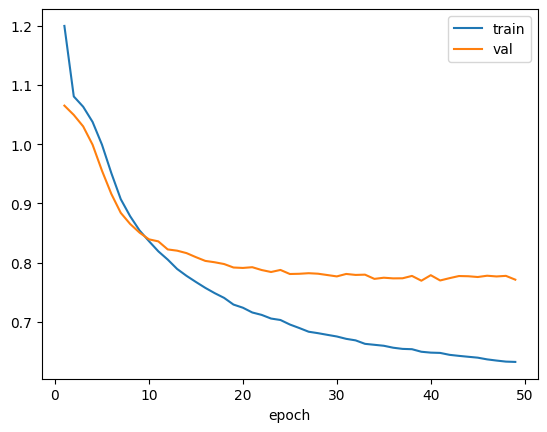

In [27]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

### evaluate model on validation set

In [28]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [29]:
final_loss = np.sqrt(np.mean((np.array(predictions) - np.array(groud_truth))**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 0.8816


In [30]:
np.array(predictions)

array([3.22362065, 2.88916826, 3.34224343, ..., 3.88819361, 3.34277844,
       3.67311811])

In [31]:
datasets["val"][0]

,user_id,movie_id
67037,341,1891
42175,83,907
93850,106,5749
6187,146,61
12229,267,154
...,...,...
57416,102,1378
67290,83,1898
33423,157,696
98552,154,7775


In [32]:
datasets["val"][1][:20000]

67037    4.0
42175    2.0
93850    4.0
6187     5.0
12229    4.0
        ... 
73415    5.0
59374    4.0
89587    3.5
30918    4.5
46482    4.5
Name: rating, Length: 20000, dtype: float32

### build a recommendation system using trained model

In [33]:
device="cpu"
def recommender_system(user_id, model, n_movies):
    model = model.to(device)
    seen_movies = set(X[X['user_id'] == user_id]['movie_id'])
    print(f"Total movies seen by the user: {len(seen_movies)}")
    user_ratings = y[X['user_id'] == user_id]
    print("=====================================================================")
    print(f"Some top rated movies (rating = {user_ratings.max()}) seen by the user:")
    print("=====================================================================\n")
    top_rated_movie_ids = X.loc[(X['user_id'] == user_id) & (y == user_ratings.max()), "movie_id"]
    print("\n".join(movies[movies.movieId.isin(top_rated_movie_ids)].title.iloc[:10].tolist()))
    print("")
    
    unseen_movies = list(set(ratings.movieId) - set(seen_movies))
    unseen_movies_index = [movie_to_index[i] for i in unseen_movies]
    
    model_input = (torch.tensor([user_id]*len(unseen_movies_index), device=device), 
                   torch.tensor(unseen_movies_index, device=device))
    
    with torch.no_grad():
        predicted_ratings = model(*model_input, minmax).detach().numpy()
    
    zipped_pred = zip(unseen_movies, predicted_ratings)
    sorted_movie_index = list(zip(*sorted(zipped_pred, key=lambda c: c[1], reverse=True)))[0]
    recommended_movies = movies[movies.movieId.isin(sorted_movie_index)].title.tolist()
    
    print("=====================================================================")
    print("Top "+str(n_movies)+" Movie recommendations for the user "+str(user_id)+ " are:")
    print("=====================================================================\n")
    print("\n".join(recommended_movies[:n_movies]))

In [34]:
recommender_system(32, net, 20)

Total movies seen by the user: 575
Some top rated movies (rating = 5.0) seen by the user:

Jumanji (1995)
GoldenEye (1995)
Friday (1995)
From Dusk Till Dawn (1996)
Fair Game (1995)
Big Bully (1996)
Screamers (1995)
Nico Icon (1995)
Doom Generation, The (1995)
Mighty Morphin Power Rangers: The Movie (1995)

Top 20 Movie recommendations for the user 32 are:

Father of the Bride Part II (1995)
Heat (1995)
Sudden Death (1995)
American President, The (1995)
Four Rooms (1995)
Get Shorty (1995)
Assassins (1995)
Powder (1995)
Persuasion (1995)
It Takes Two (1995)
Clueless (1995)
Restoration (1995)
How to Make an American Quilt (1995)
Seven (a.k.a. Se7en) (1995)
Pocahontas (1995)
When Night Is Falling (1995)
Usual Suspects, The (1995)
Mighty Aphrodite (1995)
Lamerica (1994)
Big Green, The (1995)
